### How to read:
### [LSL (LabStreamingLayer)](https://labstreaminglayer.readthedocs.io/info/intro.html) and [XDF](https://github.com/sccn/xdf) recordings
#### An example with simultaneous streams from a [mobile EEG Android App](https://github.com/adrocampos/EEG-Droid) and a [Python script sending keyboard triggers](https://github.com/mvidaldp/pylsl-keyboard-trigger).

Dependencies for reading XDF

In [1]:
import pyxdf

Dependencies for calculations and plotting

In [2]:
import itertools

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
subject='Nicolas'
file=subject+"_test.xdf"

Read file

In [4]:
data, header = pyxdf.load_xdf(file)

How the header looks like

How the recorded streams looks like

The `data` part read from the file is an array/list of dictionaries. So, each dict represents a different stream. We recorded two streams. The first one is from the [keyboard-trigger.py](https://github.com/mvidaldp/pylsl-keyboard-trigger/blob/main/keyboard-trigger.py) Python script sending triggers via keyboard press. The second is from the [mobile EEG App](https://github.com/adrocampos/EEG-Droid) sending the measured EEG channel values of the Traumschreiber (mobile EEG) device.

The keys inside each dict (stream) are explained below.

On `info` there's the recorded stream/s information (name, type, data type, hostname, uid, sampling rate, etc.)

On `footer` there's the timing information of the recorded stream/s (first and last timestamps, sample count, etc.)

On `time_series` is where the information streamed is stored.

In this case, for the keyboard triggers these are the UNIX timestamps (index 0 of each sample) plus boolean values (index 1: C4 = 1.0, C2 = 0.0) sent from the Python script [keyboard-trigger.py](https://github.com/mvidaldp/pylsl-keyboard-trigger/blob/main/keyboard-trigger.py) at each key press event.

On `time_stamps` is where the synchronized timestamps across all the streams are stored. It's time in seconds also but they are not UNIX epochs.

To visualize the data first we correct the timestamps so that they start at 0. Then we arrange each EEG channel values into a list to plot them as lines. And finally we plot the red (C2 = 0.0) or green (C4 = 1.0) vertical lines that represent our triggers.

#### Extract events and signal and plot epochs

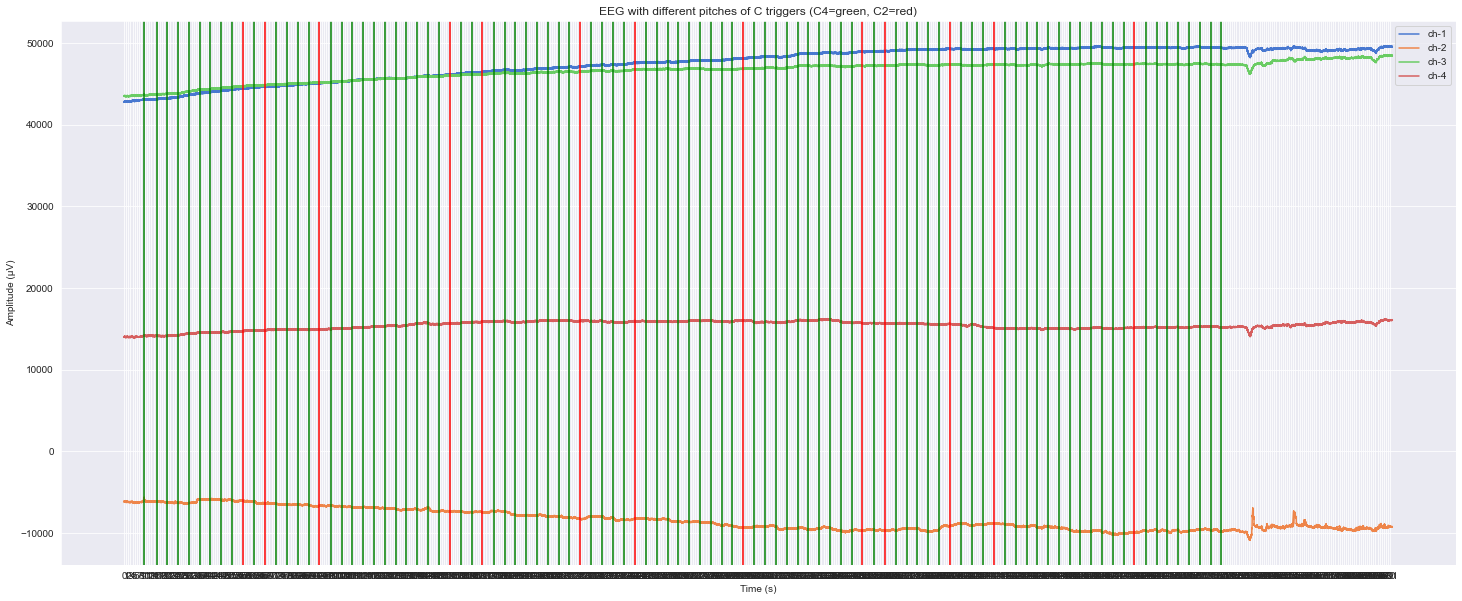

In [5]:
# calculate time values from 0
def correct_timestamps(ts):
    corrected = [0]
    length = len(ts)
    [corrected.append(ts[i + 1] - ts[0]) for i in range(length) if i < length - 1]
    return np.array(corrected)


# rewrite time starting at 0
triggers_time = data[1]["time_stamps"]
eeg_time = data[0]["time_stamps"]

t_first = triggers_time[0]
e_first = eeg_time[0]
time_diff = t_first - e_first

triggers_time = correct_timestamps(triggers_time)
eeg_time = correct_timestamps(eeg_time)

# recorrect with the difference
if time_diff < 0:
    eeg_time = np.array([i + abs(time_diff) for i in eeg_time])
else:
    triggers_time = np.array([i + time_diff for i in triggers_time])

# prepare dict for the eeg channels
eeg = {f"ch-{ch + 1}": [] for ch in range(int(data[0]["info"]["channel_count"][0]))}

# each EEG channel as a list
for sample in data[0]["time_series"]:
    for ch, value in enumerate(sample):
        eeg[f"ch-{ch + 1}"].append(value)

# prepare list for the piano triggers
triggers = []
# on index 0 we have piano triggers
# on index 1 we have eeg recording
triggers = [sample for sample in data[1]["time_series"]]

# PLOT
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(25, 10))
plt.title("EEG with different pitches of C triggers (C4=green, C2=red)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")

# each EEG channel values as a line
for i, ch in enumerate(eeg):
    if i < 6:  # all channels of this recording (6)
        sns.lineplot(x=eeg_time, y=eeg[ch], color=next(palette), label=ch)

colors = ["red", "green","black"]
# each trigger as a vertical line
for i, trigger in enumerate(triggers_time):
    if triggers[i] == 1.0:
        label = "C2" 
        color = colors[0]
    elif triggers[i] == 2.0:
        label = "C4"
        color = colors[1]
    else:
        color = colors[2] 
    plt.axvline(trigger, label=label, color=color)

plt.xticks(np.arange(0, eeg_time[-1], 1))
#plt.savefig("recording_visualization.png")
plt.show()

## MNE handling

In [6]:
import mne
from mne import Epochs

### Create a mne raw object with all infos

#### Channels

In [7]:
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep 
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['C3', 'C4', 'Cz', 'Pz']
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()
# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info

#### create raw object

In [8]:

info = mne.create_info(kept_channels, 250, ["eeg", "eeg","eeg", "eeg"])
data, header = pyxdf.load_xdf(file)
data=data[0]["time_series"].T
raw = mne.io.RawArray(data, info)
raw.set_montage(mont1020_new)
filt_raw = raw.copy().filter(l_freq=0.1, h_freq=40)
#filt_raw.plot(scalings={'eeg':'auto','misc':1e4})

Creating RawArray with float64 data, n_channels=4, n_times=150414
    Range : 0 ... 150413 =      0.000 ...   601.652 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (33.004 sec)



### add events

In [10]:

#filt_raw = raw.copy().filter(l_freq=0.1, h_freq=40)

event_dict={'C2': 1, 'C4': 2}
events=np.array([np.rint(triggers_time*250).astype(int),np.zeros(100),triggers]).astype(int).T
epochs = Epochs(filt_raw, events, event_id=event_dict,tmin=-0.2, tmax=1,baseline=None,preload=True)

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 301 original time points ...
0 bad epochs dropped


C:\Users\Client\AppData\Local\Temp/ipykernel_4640/4032515962.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  events=np.array([np.rint(triggers_time*250).astype(int),np.zeros(100),triggers]).astype(int).T


### ICA & Autoreject

In [11]:
ica = mne.preprocessing.ICA(random_state=99)
ica.fit(epochs)
#ica.plot_sources(epochs, block=True)  #plotting the sources will bug the kernel :'(

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 4 components
Fitting ICA took 0.1s.


Method,fastica
Fit,6 iterations on epochs (30100 samples)
ICA components,4
Explained variance,100.0 %
Available PCA components,4
Channel types,eeg
ICA components marked for exclusion,—


In [12]:
exclude = [0]           
ica.exclude = exclude
ica.apply(epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


Number of events,100
Events,C2: 13C4: 87
Time range,-0.200 – 1.000 sec
Baseline,off


In [13]:
epochs.plot(scalings={'eeg':'auto','misc':1e4})

Using qt as 2D backend.
Opening epochs-browser...


In [14]:
import autoreject
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=421,
                           n_jobs=1, verbose=True)
ar.fit(epochs)  # fit on a few epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/4 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=2


  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


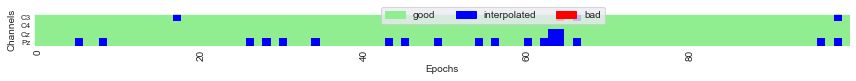

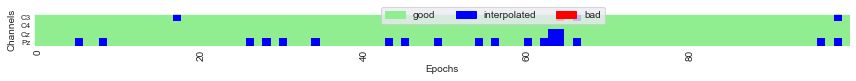

In [15]:
reject_log.plot('horizontal')

#### save into .fif file

In [16]:
raw.save(subject+'.fif', overwrite=True)

Overwriting existing file.
Writing C:\Users\Client\Desktop\Tom\edf tests\Nicolas.fif
Closing C:\Users\Client\Desktop\Tom\edf tests\Nicolas.fif
[done]


C:\Users\Client\AppData\Local\Temp/ipykernel_4640/300333582.py:1: RuntimeWarning: This filename (C:\Users\Client\Desktop\Tom\edf tests\Nicolas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(subject+'.fif', overwrite=True)


In [17]:
epochs=epochs_ar

#### GFP plots 

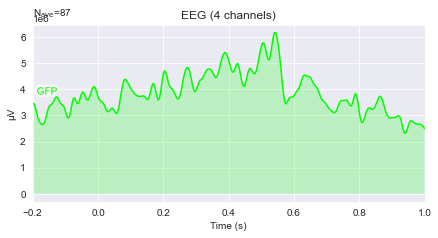

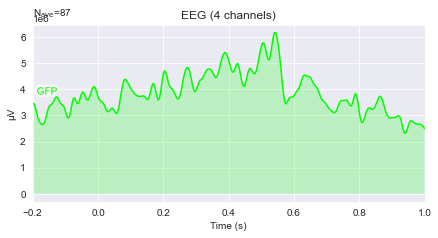

In [23]:
C4= epochs['C4'].average()
C4.plot(gfp='only')

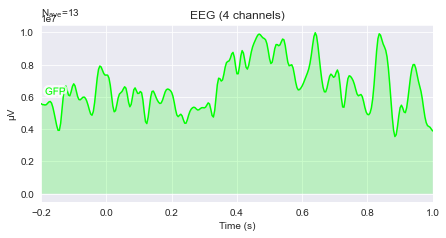

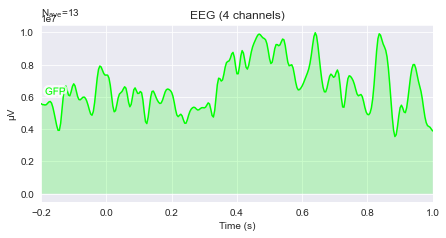

In [19]:
C2= epochs['C2'].average()
C2.plot(gfp='only')

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'GFP (µV)'), Text(0.5, 1.0, 'EEG')]

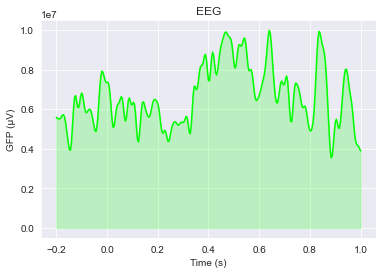

In [21]:
l_aud=C2
gfp = l_aud.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(l_aud.times, gfp * 1e6, color='lime')
ax.fill_between(l_aud.times, gfp * 1e6, color='lime', alpha=0.2)
ax.set(xlabel='Time (s)', ylabel='GFP (µV)', title='EEG')

### Plot mean ERP

combining channels using "mean"
combining channels using "mean"


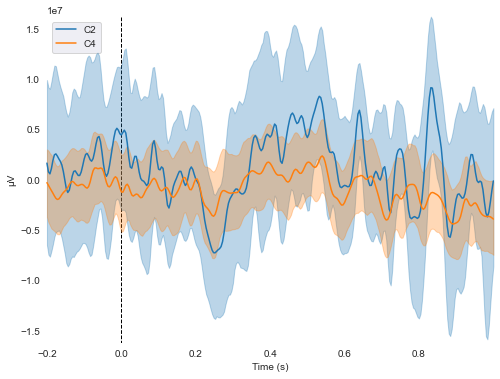

[<Figure size 576x432 with 1 Axes>]

Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [20]:
conditions = ['C2','C4']
evoked_dict = dict()
for cond in conditions:
    evoked_dict[cond] = epochs[cond].average()



evokeds_cfdt = dict(C2=list(epochs['C2'].iter_evoked()),
               C4= list(epochs['C4'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds_cfdt, combine='mean')

Opening raw data file Nicolas.fif...
    Range : 0 ... 150413 =      0.000 ...   601.652 secs
Ready.
Reading 0 ... 150413  =      0.000 ...   601.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 825 samples (3.300 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 376 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Opening raw data file Nicolas.fif...


C:\Users\Client\AppData\Local\Temp/ipykernel_4640/2661533507.py:19: RuntimeWarning: This filename (Nicolas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subject+'.fif')


    Range : 0 ... 150413 =      0.000 ...   601.652 secs
Ready.
Reading 0 ... 150413  =      0.000 ...   601.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 825 samples (3.300 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 376 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Opening raw data file Nicolas.fif...
    Range : 0 ... 150413 =      0.000 

C:\Users\Client\AppData\Local\Temp/ipykernel_4640/2661533507.py:19: RuntimeWarning: This filename (Nicolas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subject+'.fif')
C:\Users\Client\AppData\Local\Temp/ipykernel_4640/2661533507.py:19: RuntimeWarning: This filename (Nicolas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subject+'.fif')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 825 samples (3.300 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 376 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Opening raw data file Nicolas.fif...
    Range : 0 ... 150413 =      0.000 ...   601.652 secs
Ready.
Reading 0 ... 150413  =      0.000 ...   601.652 secs...
Filtering raw data in 1 contiguous 

C:\Users\Client\AppData\Local\Temp/ipykernel_4640/2661533507.py:19: RuntimeWarning: This filename (Nicolas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subject+'.fif')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


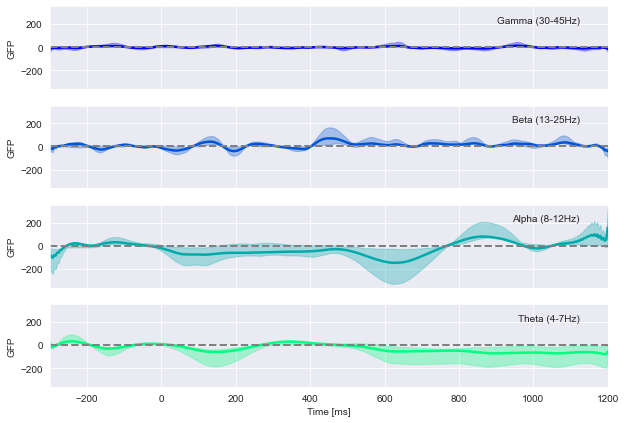

In [25]:
from mne.stats import bootstrap_confidence_interval
from mne.datasets import somato
from mne.baseline import rescale
# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]
# set epoching parameters
event_id, tmin, tmax = 1, -.3, 1.2
baseline = None

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_fif(subject+'.fif')
    raw.pick_types(eeg=True, eog=False)  # we just look at gradiometers
    raw.load_data()

    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline
                        ,preload=True)
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw


# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-300, 1200)

axes.ravel()[-1].set_xlabel('Time [ms]')
plt.savefig("GFP_"+subject+".png")
plt.show()